# ML-Algorithm practice project: Customer Aggregation with K-Means

Practice toy project on unsupervised K-means clustering to test how it fairs in a test scenario of customer aggregation


In [41]:
# Import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sea
import os
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
sns.set()
# Reading the data mall customer data into a dataframe

df_customer = pd.read_csv('Mall_Customers.csv')


In [16]:
#Check the dataframe has been parsed properly

df_customer.head(10)
print('Number of rows: {}'.format(len(df_customer)))

Number of rows: 200


From columns, we have 5 variables. Customer ID is an ordinal property, so here provides no real value and can be dropped. Gender is considered a binary categorical vairable, so must be re-coded to be in numeric format. To be more usable for the algorithm and easily fed into the model, the other variables are also best to be standardised as to follow a normal distribution (here, we'll use a mean, $\mu$, of 0, and an SD, $\sigma$, of 1 )

In [17]:
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
features = df_customer[cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns=cols)

#Show the new scaled features dataframe
scaled_features.head(10)


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
5,-1.209269,-1.662660,1.001596
6,-0.276302,-1.624491,-1.715913
7,-1.137502,-1.624491,1.700384
8,1.804932,-1.586321,-1.832378
9,-0.635135,-1.586321,0.846310


To deal with the gender variable, we need perform some numeric encoding i.e. one hot encoding. Pandas here again is useful wiht the get_dummies() method. This simply performs a quick conversion from categrocial to numeric data typing, making the converted variable a dummy/indicator variable.
Looking at the new columns, we see that the gender columns has been converted to a numeric format. The removal of the `Gender_Male` is for redundancy, as the values of this will be inverse to that of `Gender_Female` (1 for Female == 0 for Male)

In [18]:
gend = df_customer['Gender']
df_new = scaled_features.join(gend)

df_new = pd.get_dummies(df_new, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
df_new = df_new.drop(['Gender_Male'], axis=1)
df_new.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female
0,-1.424569,-1.738999,-0.434801,0
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,1
3,-1.137502,-1.700830,1.040418,1
4,-0.563369,-1.662660,-0.395980,1
5,-1.209269,-1.662660,1.001596,1
6,-0.276302,-1.624491,-1.715913,1
7,-1.137502,-1.624491,1.700384,1
8,1.804932,-1.586321,-1.832378,0
9,-0.635135,-1.586321,0.846310,1


To perform some meaningful analysis on data, we can build a K-means cluster model. This can be done for each of the variabels in the data set.
One of the initial necessary components of K-means is finding the optimal value for K itself, i.e., the number of clusters that best describes the deliniation between customers as a function of specific properties.

An somewhat quick and easy method for this is the Elbow plot, which we'll implement below

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Number of clusters'), Text(0, 0.5, 'Inertia')]

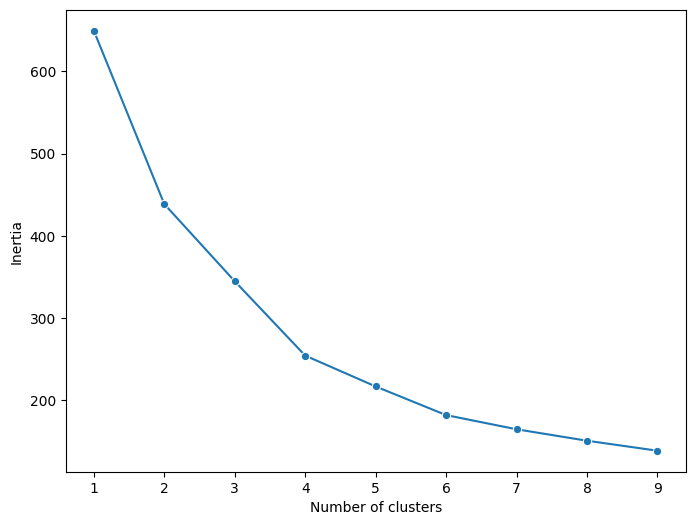

In [19]:
#Initialise an arry to store the inertia values from the KMeans fit. Inertia is a measure of how well the model performs
#with the specified number of clusters by measuring the sum of the squared differences for each point between it and 
#the centroid point the model fits them to
inertia = []

for k in range (1,10):
    kmeans = KMeans( n_clusters = k, init='k-means++')
    kmeans.fit(df_new)
    inertia.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':np.arange(1,10), 'SSE':inertia})
plt.figure(figsize=(8,6))
ax=sns.lineplot(frame['Cluster'], frame['SSE'], marker='o')
ax.set(xlabel='Number of clusters', ylabel='Inertia')

The Elbow method relies on the above stated metric of the sum of square difference from the cluster centroid, also known as the WCSS (Within-Cluster Sum of Square). The point at which a kink in the intetia curve is formed, aka an "elbow", above which increasing the number of clusters `K` produces no major improvement in interita.

From the plot above, we see can estimate that the optimum number of clusters is 4

However, we could argue theres some ambiguity in whether 4 is optimum. Maybe 7 could be a valid suspect? For this reason, its also good to implement another metric; the **Silhouette coefficient**

The silhouette coefficient/score is a metric that can be more robust than the elbow method, and results in a score ranging between -1 and 1 with meanings;

1) Points fall perfectly within clusters with clear deliniation between clusters
0) Clusters are overlapping with some wrongly assigned points
-1) Points are completely incorrectly assigned and fall within incorrect clusters

In [22]:
#Testing this out with our scaled dataframe
#start with a 4 cluster model

nclust = 4
kmeans = KMeans(n_clusters = nclust, init='k-means++')
kmeans.fit(df_new)

# Print the silhouette score of this model
print("Silhouetter score for K={} model;\t".format(str(nclust)) + str(silhouette_score(df_new, kmeans.labels_, metric='euclidean')))

Silhouetter score for K=4 model;	0.35027020434653977


We see see a SS of ~0.35, so while not awful, theres much room for improvement

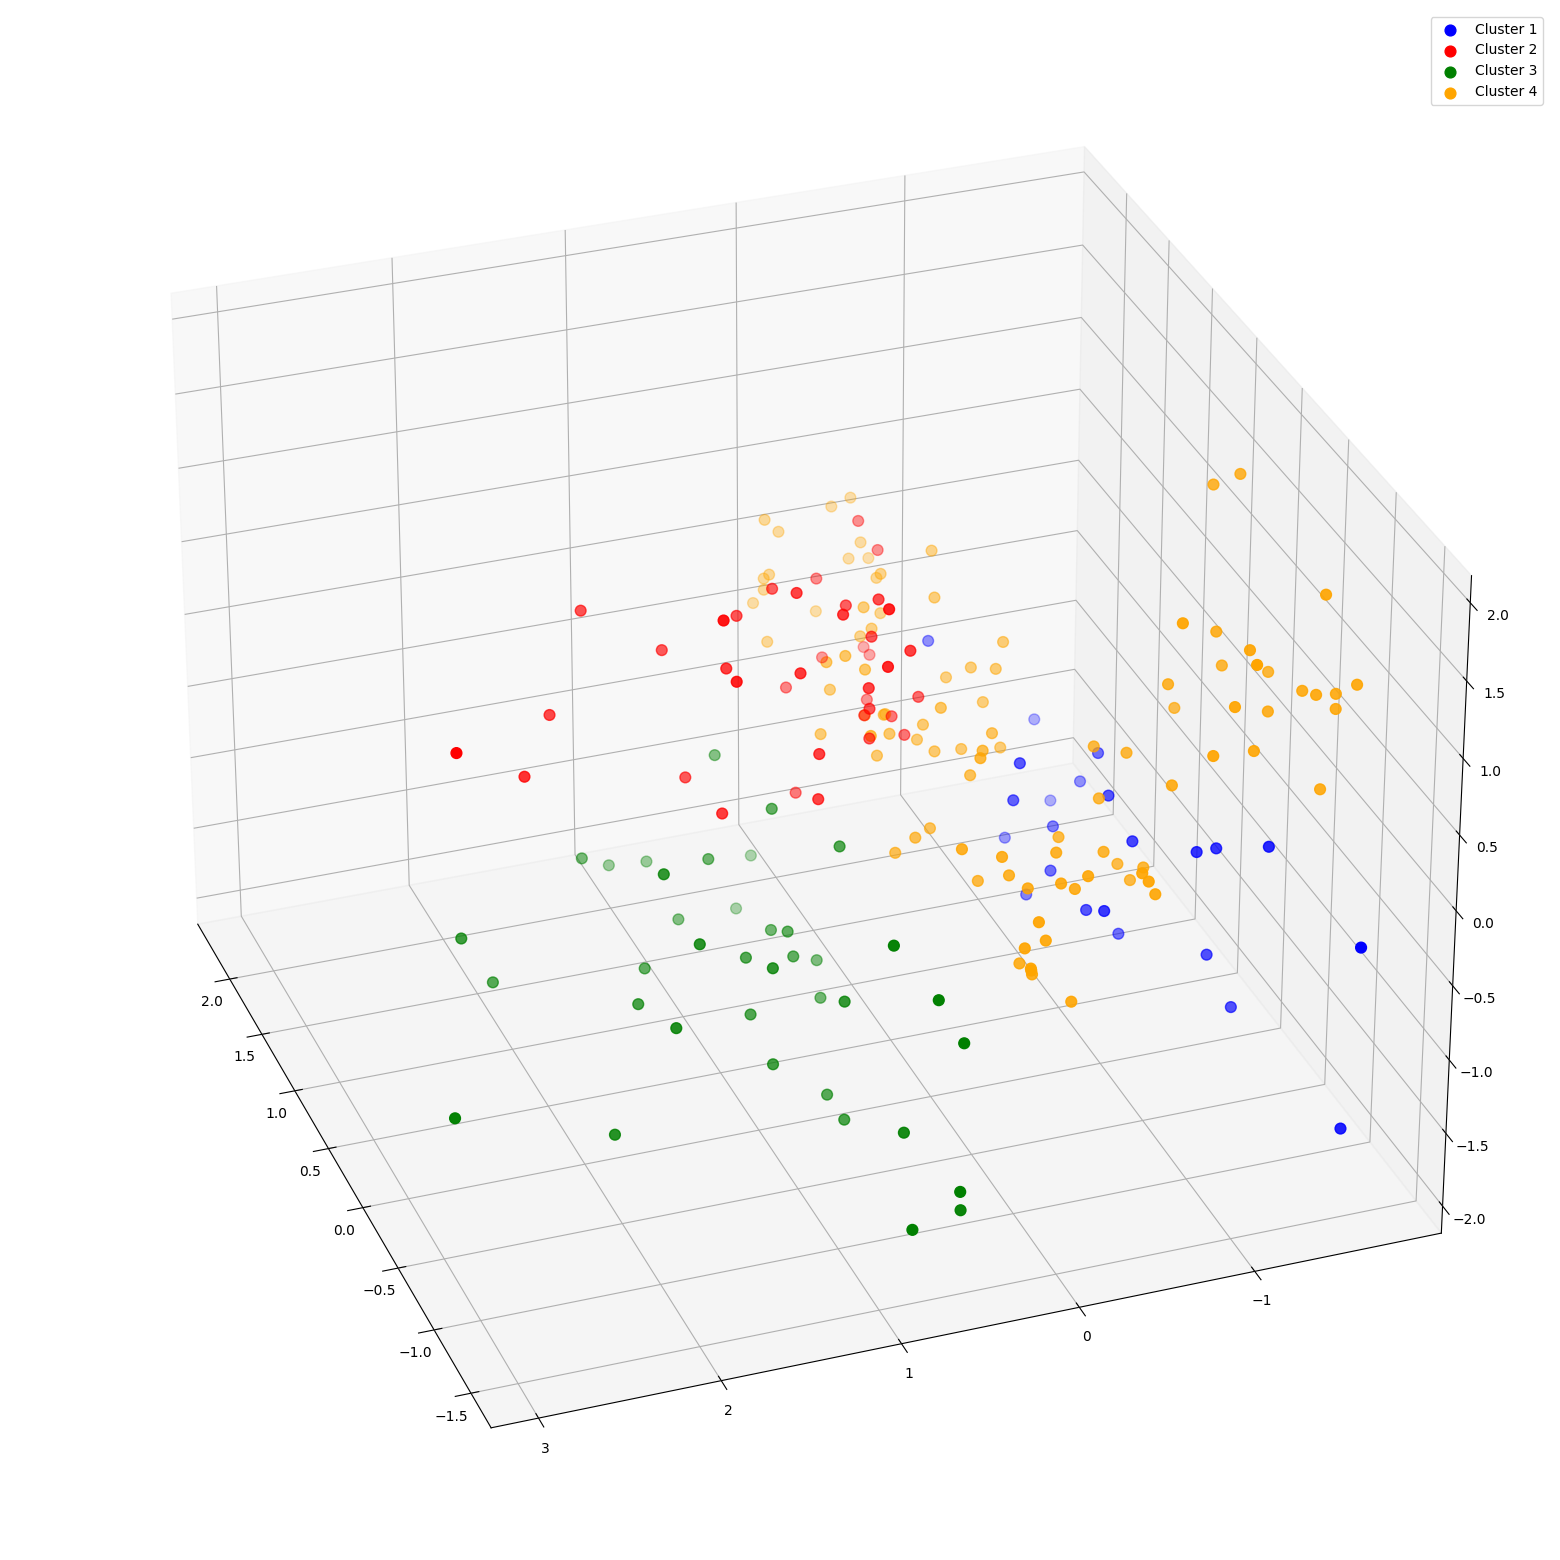

In [38]:
clusters = kmeans.fit_predict(df_new.iloc[:,1:])
df_new["label"] = clusters
 
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_new.Age[df_new.label == 0], df_new["Annual Income (k$)"][df_new.label == 0], df_new["Spending Score (1-100)"][df_new.label == 0], c='blue',label='Cluster 1', s=60)
ax.scatter(df_new.Age[df_new.label == 1], df_new["Annual Income (k$)"][df_new.label == 1], df_new["Spending Score (1-100)"][df_new.label == 1], c='red',label='Cluster 2', s=60)
ax.scatter(df_new.Age[df_new.label == 2], df_new["Annual Income (k$)"][df_new.label == 2], df_new["Spending Score (1-100)"][df_new.label == 2], c='green',label='Cluster 3', s=60)
ax.scatter(df_new.Age[df_new.label == 3], df_new["Annual Income (k$)"][df_new.label == 3], df_new["Spending Score (1-100)"][df_new.label == 3], c='orange',label='Cluster 4', s=60)

ax.view_init(30, 160)
plt.legend()
plt.show()

The above plot clearly shows that the clustering isnt optimal, with some overlap between cluster 2 and 4. So with this and the low SS in mind, clear improvements can be made. To see how we might do this, we can run some principal component analysis on the dataframe in order to gauge how significant each of the customer properties is

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


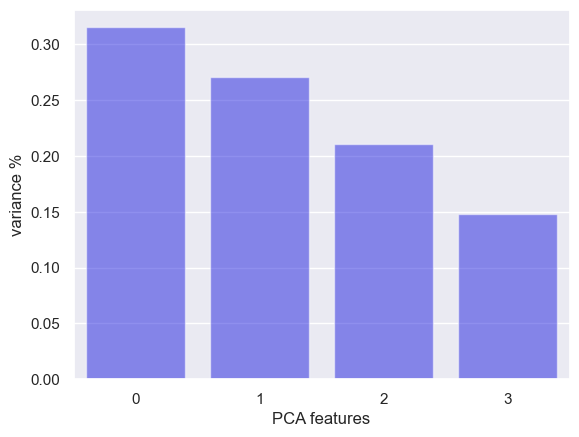

In [43]:
n_modelclust = 4
pca = PCA(n_components=n_modelclust)
principalComponents = pca.fit_transform(df_new)

features = np.arange(pca.n_components_)
ax = sns.barplot(features, pca.explained_variance_ratio_, color='blue', alpha=0.5)
ax.set(xlabel='PCA features', ylabel='Variance %')

plt.xticks(features)
plt.show()

PCA_components = pd.DataFrame(principalComponents)

From the PCA plot, we see that ~70% of the variance in the model fit is explained by the first 2 PCA fetures, so we can go back, and rebuild the K-Means model using these first 2 components instead

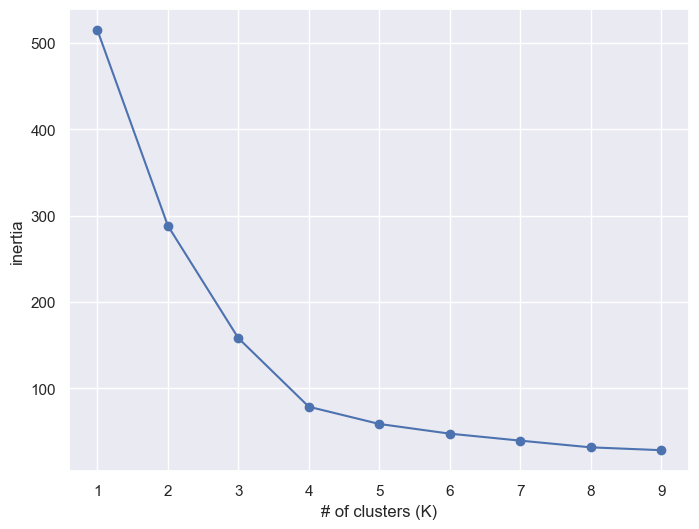

In [54]:
ks = np.arange(1, 10)
inertia = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertia.append(model.inertia_)

plt.figure(figsize=(8,6))
plt.plot(ks, inertia, marker='o')
plt.xlabel('# of clusters (K)')
plt.ylabel('inertia')

plt.xticks(ks)
plt.show()

In [55]:
nclust=4
model = KMeans(n_clusters=nclust)
model.fit(PCA_components.iloc[:,:2])

print("Silhouetter score for K={} model;\t".format(str(nclust)) + str(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')))

Silhouetter score for K=4 model;	0.581335510548771
